# Cross-correlation to find a known signal in noise

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

Consider that we are looking for a particular signal. This signal might be a little complicated, but we do know exactly what it will look like:

Text(0, 0.5, 'Signal')

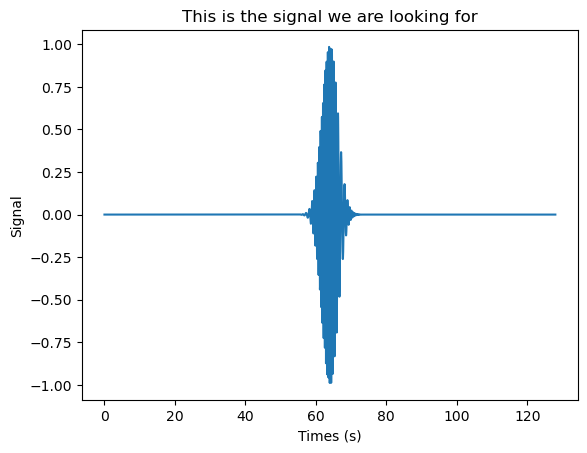

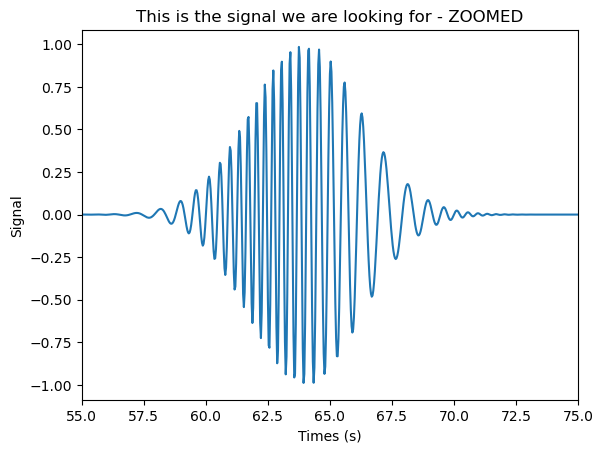

In [10]:
num_data_samples = 4096
sample_rate = 32
times = np.arange(num_data_samples) / sample_rate

gaussian_width = 5
signal_inst_frequency = 2. + 1.0*np.sin(2 * np.pi * 0.1 * times)
phases = [0]
for i in range(1,len(times)):
    phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)

sinusoid = np.sin(phases)
gaussian = np.exp( - (times - 64)**2 / (2 * gaussian_width))
#print(len(sinusoid),len(gaussian))
signal = sinusoid * gaussian

plt.figure()
plt.title("This is the signal we are looking for")
plt.plot(times, signal)
plt.xlabel('Times (s)')
plt.ylabel('Signal')

plt.figure()
plt.title("This is the signal we are looking for - ZOOMED")
plt.plot(times, signal)
plt.xlim([55,75])
plt.xlabel('Times (s)')
plt.ylabel('Signal')

However, there is also noise present in the dataset. In this case we just consider "white Gaussian noise", which is a very typical assumption. This kind of noise is a Gaussian random variable at each point in time, and there's no correlation between different times. The Fourier transform has equal power at all frequencies.

So let's add noise on top of our signal. You can see the presence of the signal, but without the noiseless example it might not be so clear that there's a signal in here!

Text(0, 0.5, 'Noise + signal')

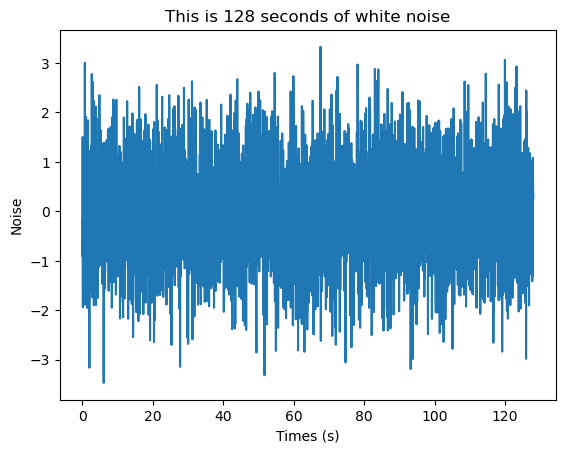

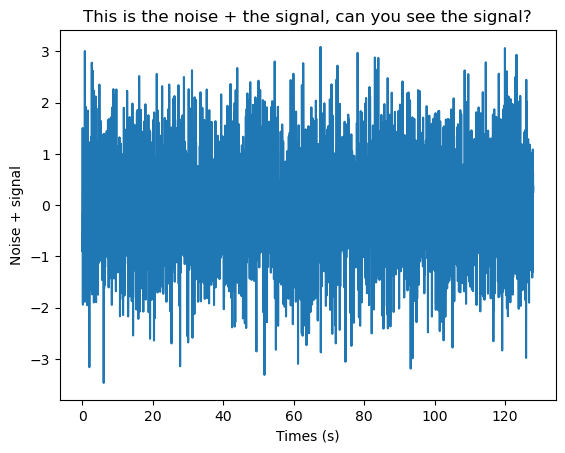

In [11]:
noise = np.random.normal(size=[num_data_samples])
plt.figure()
plt.title("This is 128 seconds of white noise")
plt.plot(times, noise)
plt.xlabel('Times (s)')
plt.ylabel('Noise')

data = signal + noise

plt.figure()
plt.title("This is the noise + the signal, can you see the signal?")
plt.plot(times, data)
plt.xlabel('Times (s)')
plt.ylabel('Noise + signal')


## Extracting the signal

So how would we know there's a signal present in the noise? We can just multiply the data with the expected signal and take the sum.

So if $s$ is the signal and $n$ is the noise and $d$ is the data, such that $d = s + n$. All of these are vectors so can be written as $s_i , d_i, n_i$, where $i$ is the index of the signal/data/noise.

If we multiply $d$ by $s$, we get

$$\sum_i d_i s_i = \sum_i (n_i + s_i) s_i = \sum_i n_i  s_i + \sum_j s_j s_j$$

Looking at these two terms, $\sum_i n_i s_i$ has an expectation value of 0 (as $n_i$ is just random white noise). It will have a non-zero variance, and this becomes our noise term, or the "confusion" making it hard to detect any potential signal.

$\sum_j s_j s_j$ will be non-zero and will have a constant value related to the amplitude of the signal. If $\sum_j s_j s_j$ is larger than the standard deviation of $\sum_i n_i  s_i$ we can start to confidently detect $s_i$ in the data.

This is called "cross-correlating" the data against the expected signal. The math works out the same regardless of the amplitude we assume for our expected signal ... so we don't need to know how loud our signal will be (although quieter signals will be harder to extract). A standard approach here is to choose the amplitude of the expected signal such that the expected variance of $\sum_i n_i  s_i$ will be 1. In this way $\sum_i d_i s_i$ becomes a signal-to-noise ratio!

Let's compute $\sum_i d_i s_i$ and $\sum_i n_i  s_i$ for our datasets.

In [12]:
print("Cross correlation of data and signal:", (data * signal).sum())
print("Cross correlation of noise and signal:", abs((noise * signal).sum()))

Cross correlation of data and signal: 53.4931239529548
Cross correlation of noise and signal: 9.92011282707601


With a signal present we get a value around 60. A number this large will occur only *extremely* rarely if no signal is present ... We'll discuss significance in the next lecture. For now we can demonstrate that this is extremely rare in noise alone by generating a hundred thousand different noisy datasets and seeing what the largest value that we get for this multiplication is.

In [13]:
max_sum = 0
for i in range(100000):
    curr_noise = np.random.normal(size=[num_data_samples])
    current_sum = (curr_noise * signal).sum()
    if abs(current_sum) > max_sum:
        max_sum = abs(current_sum)

print("Largest value was", max_sum, "still much less than 60.")



Largest value was 34.3935431830671 still much less than 60.


Alternatively we can normalize our signal by dividing by $\sqrt{\sum_j s_j s_j}$.

In [14]:
# The normalization must be the square-root of the cross-correlation
norm_value = ((signal * signal).sum())**0.5
# Normalize the signal
template = signal / norm_value
# Then this should be 1
print("Should be 1", ((template * template).sum()))

print("Cross correlation of data and normalized signal:", (data * signal).sum())
print("Cross correlation of noise and normalized signal:", abs((noise * signal).sum()))


### Are you here in regards to the coursework? A hint: Here we are normalizing the signal. Here, the data is
### *already* normalized. What would you do if the data is not already normalized (the answer is *not* to
### divide by the same factor but with the noise instead of the signal)

Should be 1 1.0000000000000002
Cross correlation of data and normalized signal: 53.4931239529548
Cross correlation of noise and normalized signal: 9.92011282707601


And again we can simulate 100000 realizations of this noise and see what the distribution of this cross-correlation is:

Largest value was 4.286499728793476 still much less than 60.


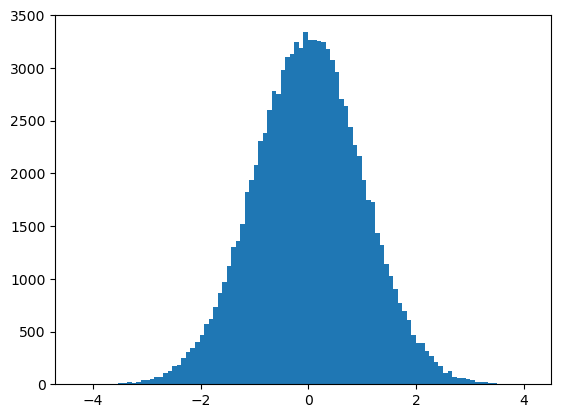

In [15]:
vals = []
max_sum = 0
for i in range(100000):
    curr_noise = np.random.normal(size=[num_data_samples])
    current_sum = (curr_noise * template).sum()
    vals.append(current_sum)
    if abs(current_sum) > max_sum:
        max_sum = abs(current_sum)
        vals.append(current_sum)

print("Largest value was", max_sum, "still much less than 60.")
_,_,_, = plt.hist(vals, bins=100)

This is a Gaussian distribution with mean 0 and variance 1. A value of close to 8 is extremely unlikely here, and so we can confidently extract the signal we added to this noise!

## Exercise

Calculating the cross-correlation as a function of time

In our previous example we knew where the signal was in the time-series. However, in many applications we do not know if a signal is present, and we would not know where it is present in the data stream.

Here the task is to compute the "cross-correlation" between the signal and our noisy data stream as a function of time. This should be done in a number of steps

* Cut the signal vector so that it is 32 seconds long (512 samples) centered on the peak of the signal, which occurs at 64 seconds.
* Plot the reduced signal
* This 32-second long signal can then be multiplied, and the result summed, with any 32-second long stretch of the data. Choose a random 32-second long stretch of the data and do this.
* Choose the 32-second stretch of data centered on 64 seconds, where the signal is, and do this again.
* Calculate the summed muliplication between the signal and data as a function of time. That is multiply `template` by `data[i:i+(len(template))]` with `i` varying to cover the full length of the data.
* Plot this as a function of time. Can you see the real signal stand out?